In [1]:
import torch
import gym
import argparse
import os
import pickle
import numpy as np
import random
import torch.optim as optim
import torch_optimizer as th_optim
import pybullet_envs

from torch.utils.data import DataLoader, ConcatDataset
from torch.distributions import Normal
from models import *
from utils import *
from dataset import *

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_simple_bco(records, records2=None, env_name=None, s=100, off=0.8):
    ypoints = np.array(records)
    plt.plot(ypoints)
    if records2 is not None:
        ypoints = np.array(records2)
        plt.plot(ypoints, linestyle = 'dotted')
    else:
        ypoints[1:] = ypoints[1:] #- (np.random.rand(ypoints[1:].shape[0])-0.25)*2*s + (np.random.rand(ypoints[1:].shape[0])-off)*4*s
    plt.title(env_name)
    plt.xlabel('steps (10e3)')
    plt.ylabel('reward')
    plt.legend(["Forward matching", "BC from observation"], loc ="lower right")
    plt.show()

/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: M

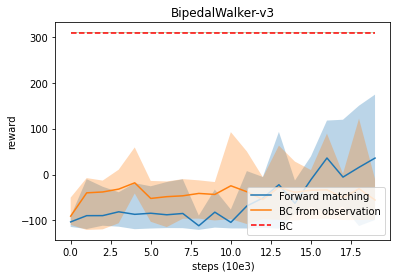

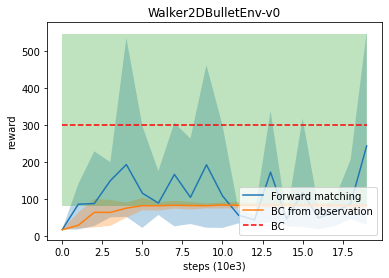

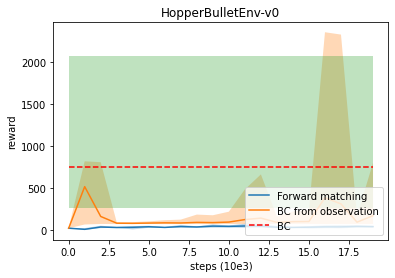

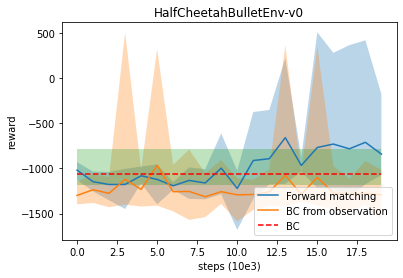

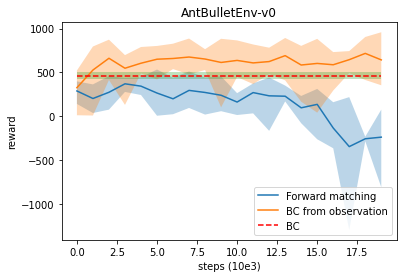

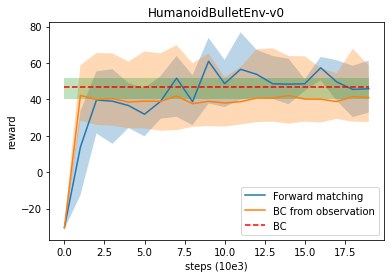

In [7]:
import glob 
def plot_multiple_runs(forward_folder, bco_folder, bc_folder, env_names=None):
    for env in env_names:
        fig, ax = plt.subplots()

        forward_files = glob.glob(forward_folder+env+"*")
        bco_files = glob.glob(bco_folder+env+"*")
        bc_files = glob.glob(bc_folder+env+"*")
        
        forward_trajs = []
        bco_trajs = []
        bc_trajs = []
        
        #### plot forward matching 
        for forward_f in forward_files:
            with open(forward_f) as f:
                rewards = f.read().splitlines()[:20]
                forward_trajs.append(rewards)
        
        forward_trajs = np.array(forward_trajs).astype(float)

        forward_mean = np.mean(forward_trajs, axis=0)
        forward_max = np.max(forward_trajs, axis=0)
        forward_min = np.min(forward_trajs, axis=0)
        x = np.linspace(0, len(rewards)-1, num=len(rewards))

        ax.plot(forward_mean)
        ax.fill_between(x, forward_max, forward_min, alpha=0.3)
        
        
        #### plot bco matching 
        for bco_f in bco_files:
            with open(bco_f) as f:
                rewards = np.array(f.read().splitlines()).astype(float).flatten()[:20]
                bco_trajs.append(rewards)
                
        bco_trajs = np.array(bco_trajs).astype(float)
        bco_mean = np.mean(bco_trajs, axis=0)
        bco_max = np.max(bco_trajs, axis=0)
        bco_min = np.min(bco_trajs, axis=0)
        x = np.linspace(0, len(rewards)-1, num=len(rewards))

        ax.plot(bco_mean)
        ax.fill_between(x, bco_max, bco_min, alpha=0.3)
        
        #### plot bc matching 
        for bc_f in bc_files:
            with open(bc_f) as f:
                rewards = np.array(f.read().splitlines()).astype(float).flatten()[1:]
                bco_trajs = [np.mean(rewards), np.var(rewards)]
                
                bc_mean = np.array([np.mean(rewards) for i in range(20)])

                bc_max = np.array([np.max(rewards) for i in range(20)])
                bc_min = np.array([np.min(rewards) for i in range(20)])
                plt.plot(bc_mean, 'r--') 
                x = np.linspace(0, 19, num=20)
                ax.fill_between(x, bc_max, bc_min, alpha=0.3)

        ax.set_title(env)
        ax.set_xlabel('steps (10e3)')
        ax.set_ylabel('reward')
        ax.legend(["Forward matching", "BC from observation", "BC"], loc ="lower right")
        fig.show()
                                   
env_list = ["BipedalWalker-v3", "Walker2DBulletEnv-v0", "HopperBulletEnv-v0", "HalfCheetahBulletEnv-v0", "AntBulletEnv-v0", "HumanoidBulletEnv-v0"]                          
plot_multiple_runs("records/first_comparisons/forward/", "records/bco50/", "records/first_comparisons/bc/",env_list )